In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt

/tmp/ipykernel_2501434/2312776519.py:21: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [18]:
import importlib
importlib.reload(dp)
importlib.reload(dplt)

<module 'functions_plotting' from '/home/s377963/car_t_sc/02_code/functions/functions_plotting.py'>

### Import the preprocessed data

In [229]:
#for the data from R
# adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_calagry_exact.h5ad')
adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_pseudocount.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_abs_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_soupx_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad')

In [230]:
#just for the HTODemux processed data, since the nomenclature was different within the calagry script
adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
adata.obs['dataset'] = rmvd_p

In [231]:
nas = pd.isna(adata.obs['Tcell_subtype']) #functional.cluster or Tcell_subtype
adata_nona = adata[~nas,:].copy()

In [232]:
days = ['0', '7', '14']
conditions = ['C', 'DM', 'P']
dplt.add_DaysConds_to_adata(adata_nona, days, conditions)

In [ ]:
conditions = np.unique(adata.obs.condition.values)
days = sorted(np.unique(adata.obs.day), key=lambda x: int(x), reverse=True)
# Filter for only selected subtype
subtype_only = list(map(lambda subtype: cell_subtype in subtype, adata.obs[obs_column]))
adata = adata[subtype_only, :].copy()
unq_celltypes = np.unique(adata.obs[obs_column])
# Set up subplots for each condition
fig, axs = plt.subplots(len(conditions), figsize=(8, 6)) #, sharey=True
# Plot each condition in a separate subplot
for idx, condition in enumerate(conditions):
    ax = axs[idx] if len(conditions) > 1 else axs  # Handles case with only one condition
    subset = adata[adata.obs.condition == condition, :]
    
    # Initialize dictionary for each celltype's counts by day
    celltype_counts = {celltype: [] for celltype in unq_celltypes}
    
    for celltype in unq_celltypes:
        celltype_subset = subset[subset.obs[obs_column] == celltype, :]
        for day in days:
            day_subset = celltype_subset[celltype_subset.obs.day == day, :]
            day_count = len(day_subset)  # Count the entries for each day and cell type
            celltype_counts[celltype].append(day_count)
    # Normalize cell type counts by day
    norm_factors = [sum(day_counts) for day_counts in zip(*celltype_counts.values())]
    norm_factors = [nf if nf > 0 else 1 for nf in norm_factors] 
    for key, values in celltype_counts.items():
        celltype_counts[key] = (np.array(values) / norm_factors) * 100

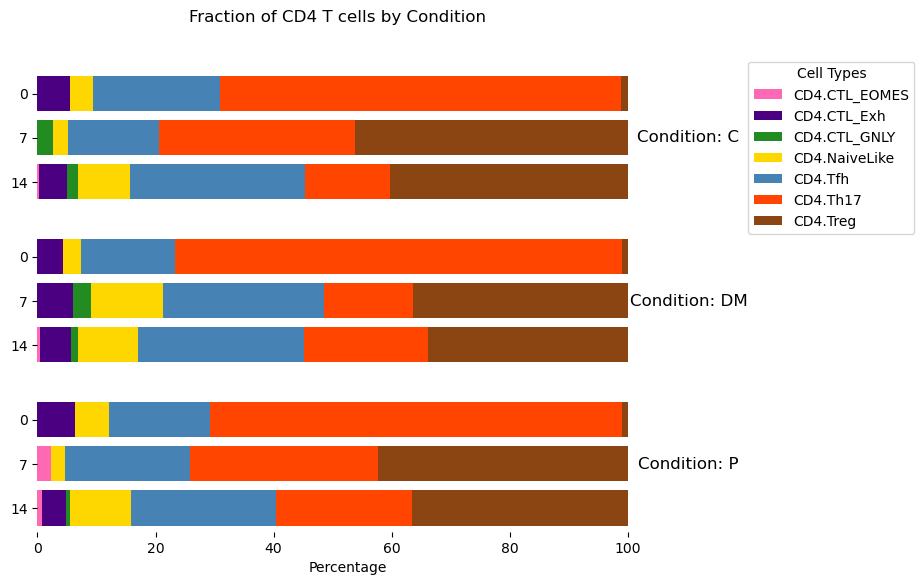

In [29]:
# for the mad filtered hashsolo data
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
# dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

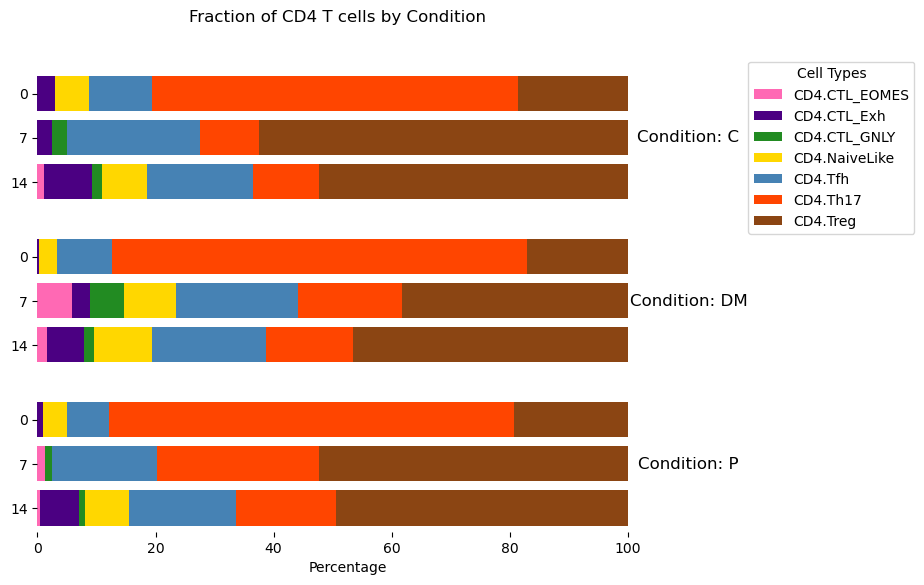

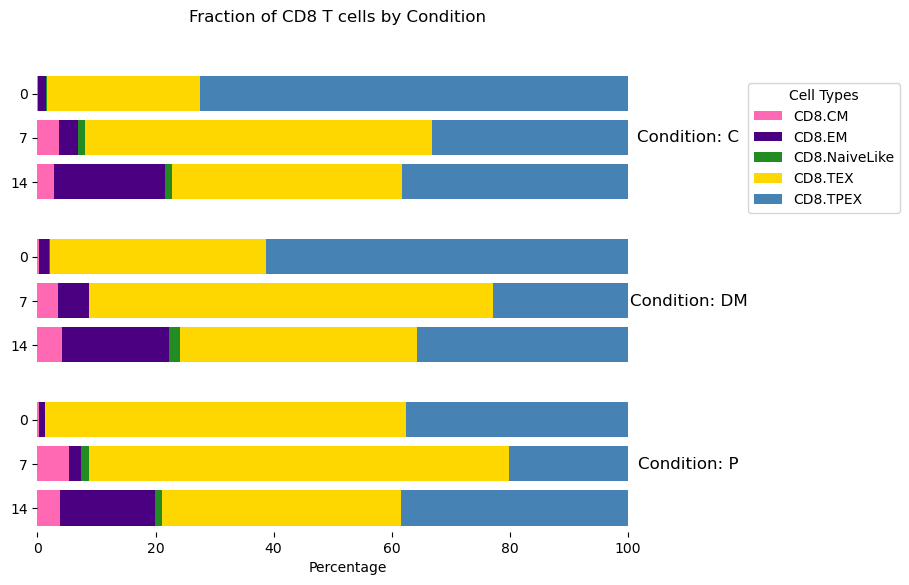

In [24]:
# for the abs filtered hashsolo data not utilising soupX
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

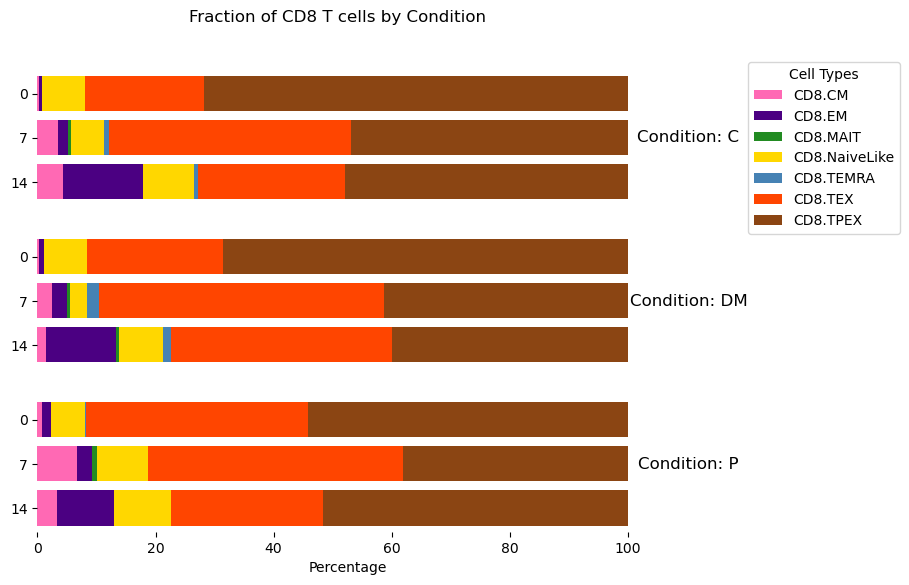

In [20]:
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

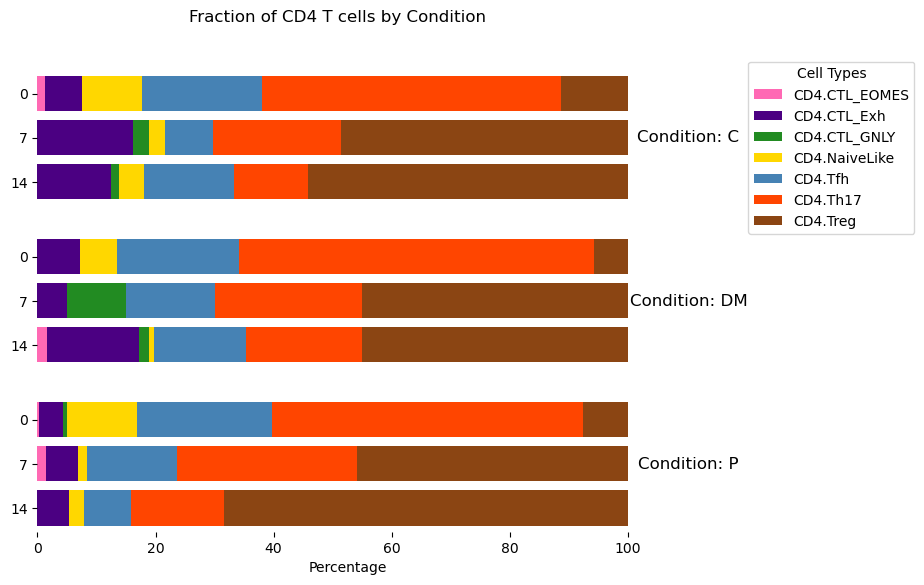

In [18]:
# for the abs filtered HTODemux data utiloizing pseudocounts
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
# dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

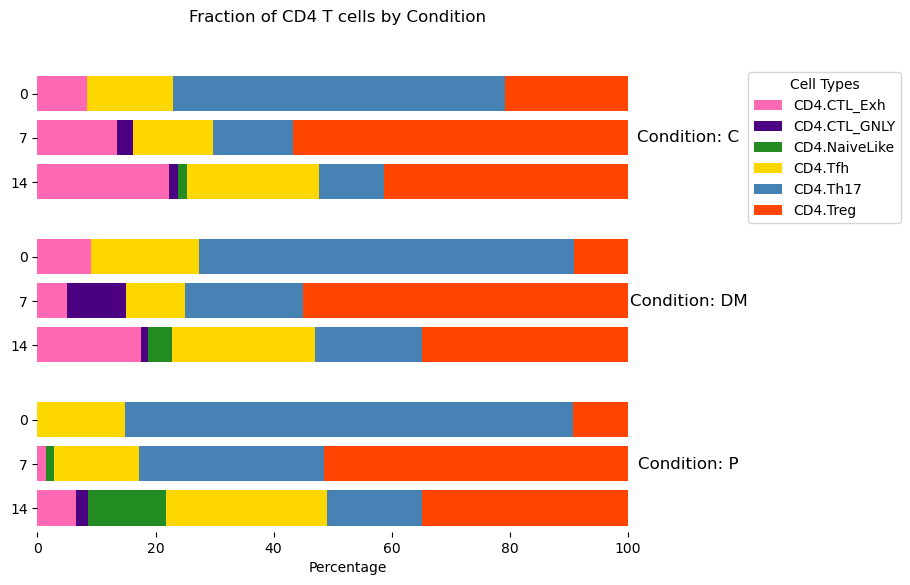

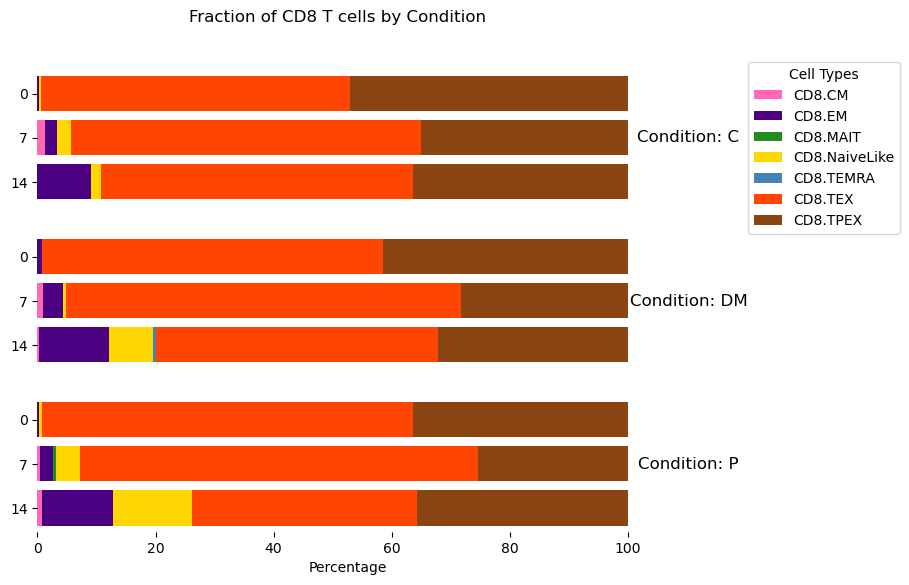

In [ ]:
# for the abs filtered HTODemux data (exactly like calagry)
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

# Annotate CARs

In [ ]:
p1_GEX_car_mapped = pd.read_csv('./01_data/processed/count_cart_receptor/P1_GEX.csv')
p1_VDJ_car_mapped = pd.read_csv('./01_data/processed/count_cart_receptor/P1_VDJ.csv')

In [ ]:
p1_VDJ_car_mapped = p1_VDJ_car_mapped.drop(columns=['ReadIDs'])
p1_GEX_car_mapped = p1_GEX_car_mapped.drop(columns=['ReadIDs'])
p1_merged = pd.merge(p1_GEX_car_mapped, p1_VDJ_car_mapped, on="Cellbarcode", how='outer') #, on="Cellbarcode", how='outer'
p1_merged.fillna(0, inplace=True)
p1_merged['CD19_trunc'] = p1_merged['CD19_trunc_x'] + p1_merged['CD19_trunc_y']
p1_merged['R11_ScFV'] = p1_merged['R11_ScFV_x'] + p1_merged['R11_ScFV_y']
p1_merged = p1_merged.filter(items=['CD19_trunc', 'R11_ScFV'])

In [97]:
mylist = ["dog", "cat", "wildcat", "thundercat", "cow", "hooo"]
r = re.compile(".*cat")
newlist = list(filter(r.match, mylist)) # r.match generates a function that takes any string as an input an returns true or false depending on whether the string could be matched
print(newlist)

['cat', 'wildcat', 'thundercat']


In [157]:
import importlib
importlib.reload(dp)
importlib.reload(dplt)

<module 'functions_plotting' from '/home/s377963/car_t_sc/02_code/functions/functions_plotting.py'>

In [233]:
path = './01_data/processed/count_cart_receptor'
VDJ_GEX_list = dplt.read_and_merge_CAR_annotation(path)
merged = [dplt.merge_VDJ_and_GEX(GEX, VDJ) for (GEX, VDJ) in zip(*VDJ_GEX_list)]
cars_annotated = dplt.annotate_mapped_cars(adata_nona, merged)

/home/s377963/car_t_sc/02_code/functions/functions_plotting.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged.fillna(0, inplace=True)
/home/s377963/car_t_sc/02_code/functions/functions_plotting.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged.fillna(0, inplace=True)
/home/s377963/car_t_sc/02_code/functions/functions_plotting.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavi

In [234]:
#for HTODemux pseudocount
only_cars = cars_annotated[cars_annotated.obs.isCAR]
only_cars.obs.groupby('dataset').size()

dataset
0    3144
1       2
4       1
dtype: int64

In [228]:
#for calagry exact
only_cars = cars_annotated[cars_annotated.obs.isCAR]
only_cars.obs.groupby('dataset').size()

dataset
0    1176
1       1
4       1
6       1
dtype: int64

In [213]:
#for abs
only_cars = cars_annotated[cars_annotated.obs.isCAR]
only_cars.obs.groupby('dataset').size()

/tmp/ipykernel_2501434/3778291709.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_cars.obs.groupby('dataset').size()


dataset
0    2969
1       2
5       2
6       2
7       1
8       1
dtype: int64

In [218]:
#for mad - soupx
only_cars = cars_annotated[cars_annotated.obs.isCAR]
only_cars.obs.groupby('dataset').size()

/tmp/ipykernel_2501434/3605940356.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_cars.obs.groupby('dataset').size()


dataset
0    3038
1       2
5       2
6       2
7       1
8       1
dtype: int64

In [ ]:
#for mad + soupx
only_cars = cars_annotated[cars_annotated.obs.isCAR]
only_cars.obs.groupby('dataset').size()

/tmp/ipykernel_2501434/2481225620.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_cars.obs.groupby('dataset').size()


dataset
0    3034
1       2
5       2
6       2
8       1
dtype: int64